# Crop Pest Detection Model

This notebook trains a MobileNetV3-based pest classifier using transfer learning on Kaggle.

It's designed to:
- Classify crop pest images into multiple categories
- Support incremental retraining with new data
- Provide confidence scores with predictions
- Be easily integrated into web APIs or mobile applications


**Dataset:** [Pest Dataset](https://www.kaggle.com/datasets/simranvolunesia/pest-dataset)

In [1]:
# Install required packages
!pip install -q tensorflow numpy pandas matplotlib seaborn scikit-learn pillow

print("✓ Packages installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 6.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 202

## 2. Setup Directories

Configure paths for Kaggle environment.

In [2]:
import os
from pathlib import Path

# Kaggle dataset path
KAGGLE_INPUT = '/kaggle/input/pest-dataset/pest'

# Working directory paths
WORKING_DIR = '/kaggle/working'
MODELS_DIR = os.path.join(WORKING_DIR, 'models')

# Dataset paths (using Kaggle input)
TRAIN_DIR = os.path.join(KAGGLE_INPUT, 'train')
TEST_DIR = os.path.join(KAGGLE_INPUT, 'test')

# Create models directory
os.makedirs(MODELS_DIR, exist_ok=True)

# Verify dataset structure
print("="*60)
print("KAGGLE ENVIRONMENT SETUP")
print("="*60)
print(f"Kaggle Input: {KAGGLE_INPUT}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Test Directory: {TEST_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print()

# Check if dataset exists
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    print("✓ Dataset found successfully!")
    print(f"  Train classes: {len(os.listdir(TRAIN_DIR))}")
    print(f"  Test classes: {len(os.listdir(TEST_DIR))}")
else:
    print("⚠ Dataset not found!")
    print("\nPlease add the dataset:")
    print("  1. Click '+ Add Data' button")
    print("  2. Search for 'pest-dataset' by simranvolunesia")
    print("  3. Click 'Add' to attach it to this notebook")
    raise FileNotFoundError("Dataset not found. Please add the pest-dataset to your Kaggle notebook.")

print("="*60)

KAGGLE ENVIRONMENT SETUP
Kaggle Input: /kaggle/input/pest-dataset/pest
Train Directory: /kaggle/input/pest-dataset/pest/train
Test Directory: /kaggle/input/pest-dataset/pest/test
Models Directory: /kaggle/working/models

✓ Dataset found successfully!
  Train classes: 9
  Test classes: 9


## 3. Data Exploration

Explore the dataset structure and visualize sample images.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Count images per class
def count_images_in_dir(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            counts[class_name] = len(image_files)
    return counts

train_counts = count_images_in_dir(TRAIN_DIR)
test_counts = count_images_in_dir(TEST_DIR)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTotal classes: {len(train_counts)}")
print(f"Total training images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")
print(f"\nClass distribution:")
for class_name in sorted(train_counts.keys()):
    print(f"  {class_name:20s}: {train_counts[class_name]:4d} train, {test_counts.get(class_name, 0):4d} test")
print("="*60)


DATASET SUMMARY

Total classes: 9
Total training images: 2700
Total test images: 450

Class distribution:
  aphids              :  300 train,   50 test
  armyworm            :  300 train,   50 test
  beetle              :  300 train,   50 test
  bollworm            :  300 train,   50 test
  grasshopper         :  300 train,   50 test
  mites               :  300 train,   50 test
  mosquito            :  300 train,   50 test
  sawfly              :  300 train,   50 test
  stem_borer          :  300 train,   50 test


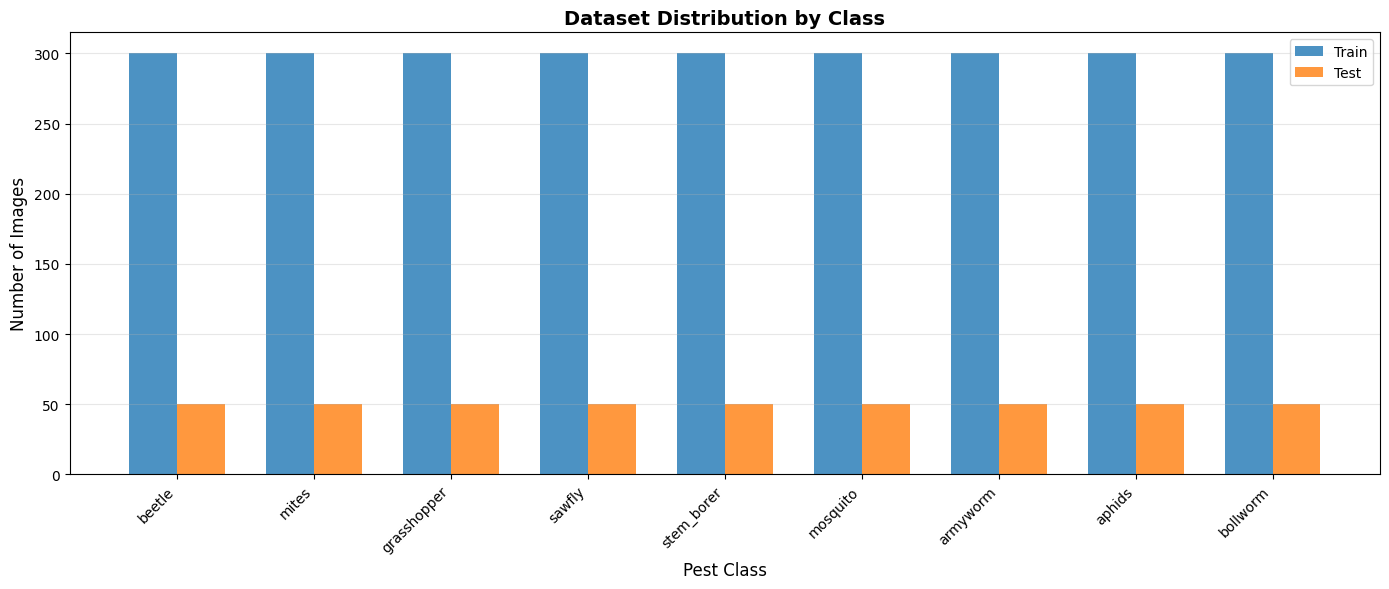

In [4]:
# Visualizing class distribution
import pandas as pd
import seaborn as sns

plt.figure(figsize=(14, 6))

# Create dataframe
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Test': [test_counts.get(c, 0) for c in train_counts.keys()]
})

# Plot
df_counts_sorted = df_counts.sort_values('Train', ascending=False)
x = np.arange(len(df_counts_sorted))
width = 0.35

plt.bar(x - width/2, df_counts_sorted['Train'], width, label='Train', alpha=0.8)
plt.bar(x + width/2, df_counts_sorted['Test'], width, label='Test', alpha=0.8)

plt.xlabel('Pest Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
plt.xticks(x, df_counts_sorted['Class'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

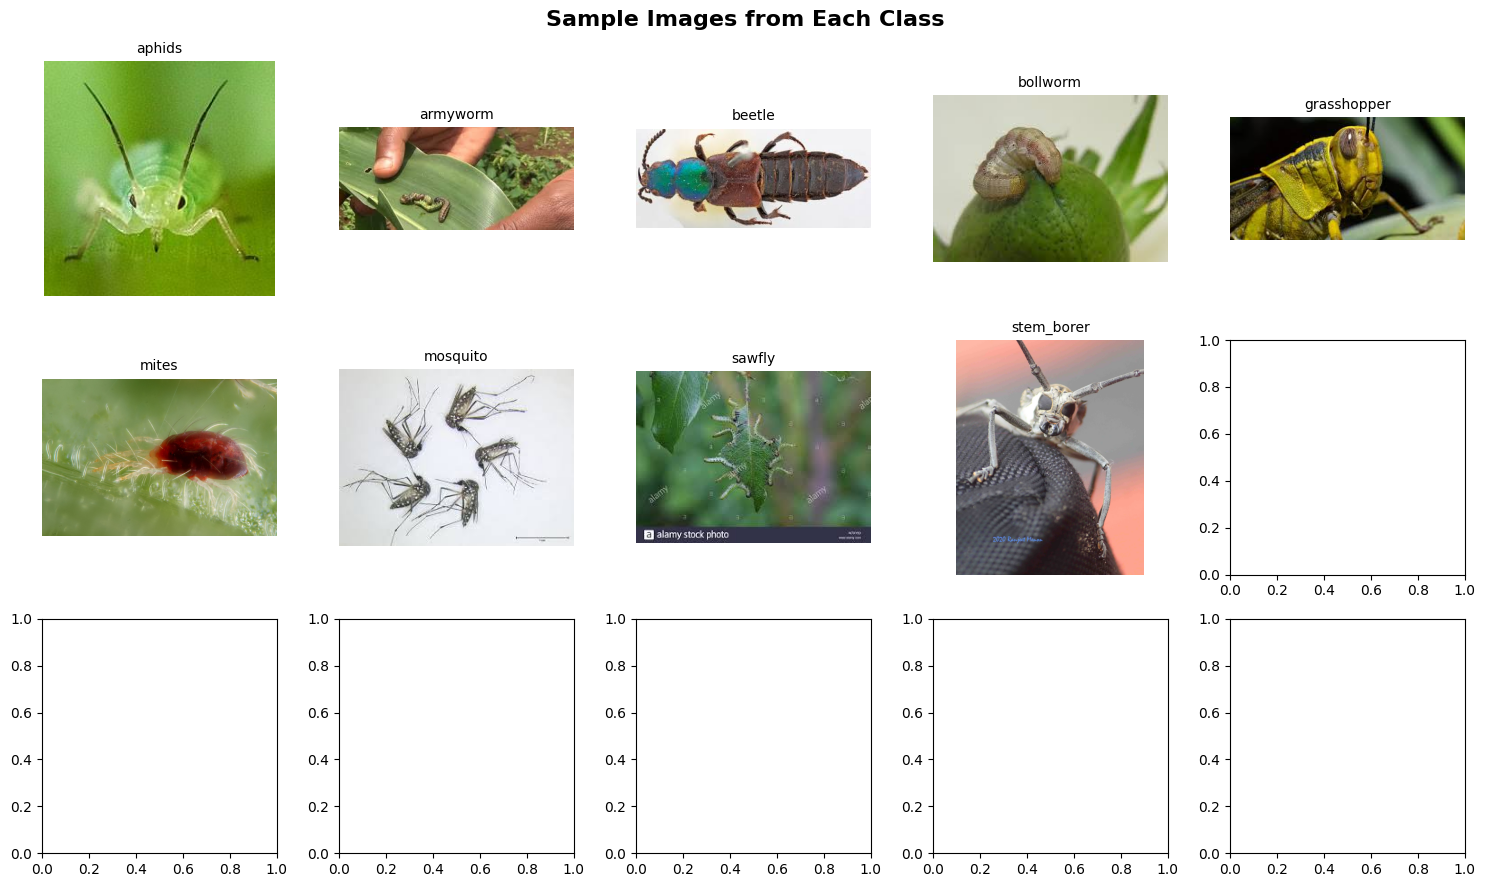

In [6]:
# Visualizing sample images from each class
class_names = sorted(train_counts.keys())
num_classes = len(class_names)

fig, axes = plt.subplots(3, min(5, num_classes), figsize=(15, 9))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(class_names[:15]):  # Show max 15 classes
    row = idx // 5
    col = idx % 5
    
    class_dir = os.path.join(TRAIN_DIR, class_name)
    images = [f for f in os.listdir(class_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if images:
        img_path = os.path.join(class_dir, images[0])
        img = Image.open(img_path)
        
        if num_classes <= 5:
            axes[col].imshow(img)
            axes[col].set_title(class_name, fontsize=10)
            axes[col].axis('off')
        else:
            axes[row, col].imshow(img)
            axes[row, col].set_title(class_name, fontsize=10)
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Set up data generators with augmentation for training.

In [ ]:
# Defining DataPreprocessor for Kaggle - Enhanced version
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

class DataPreprocessor:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
    
    def create_train_generator(self):
        """Enhanced data augmentation for better generalization"""
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=40,              # Increased from 30
            width_shift_range=0.25,          # Increased from 0.2
            height_shift_range=0.25,         # Increased from 0.2
            shear_range=0.25,                # Increased from 0.2
            zoom_range=0.25,                 # Increased from 0.2
            brightness_range=[0.8, 1.2],     # NEW: brightness augmentation
            horizontal_flip=True,
            vertical_flip=True,
            channel_shift_range=20.0,        # NEW: color variation
            fill_mode='nearest',
            validation_split=0.2
        )
    
    def create_test_generator(self):
        return ImageDataGenerator(preprocessing_function=preprocess_input)
    
    def load_train_data(self, train_dir):
        train_datagen = self.create_train_generator()
        train_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', subset='training', shuffle=True
        )
        val_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', subset='validation', shuffle=True
        )
        return train_gen, val_gen
    
    def load_test_data(self, test_dir):
        test_datagen = self.create_test_generator()
        return test_datagen.flow_from_directory(
            test_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )

print("✓ Enhanced DataPreprocessor ready")

2025-11-27 15:08:35.676994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764256115.851291      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764256115.900768      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ DataPreprocessor ready


In [8]:
# Initialize preprocessor
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

preprocessor = DataPreprocessor(img_size=IMG_SIZE, batch_size=BATCH_SIZE)

# Load data
print("Loading training and validation data...")
train_generator, validation_generator = preprocessor.load_train_data(TRAIN_DIR)

print("\nLoading test data...")
test_generator = preprocessor.load_test_data(TEST_DIR)

# Get class information
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"\n✓ Data loaded successfully!")
print(f"  Classes: {num_classes}")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"\n  Class names: {class_names}")

Loading training and validation data...
Found 2160 images belonging to 9 classes.
Found 540 images belonging to 9 classes.

Loading test data...
Found 450 images belonging to 9 classes.

✓ Data loaded successfully!
  Classes: 9
  Training samples: 2160
  Validation samples: 540
  Test samples: 450

  Class names: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


Visualizing data augmentation...


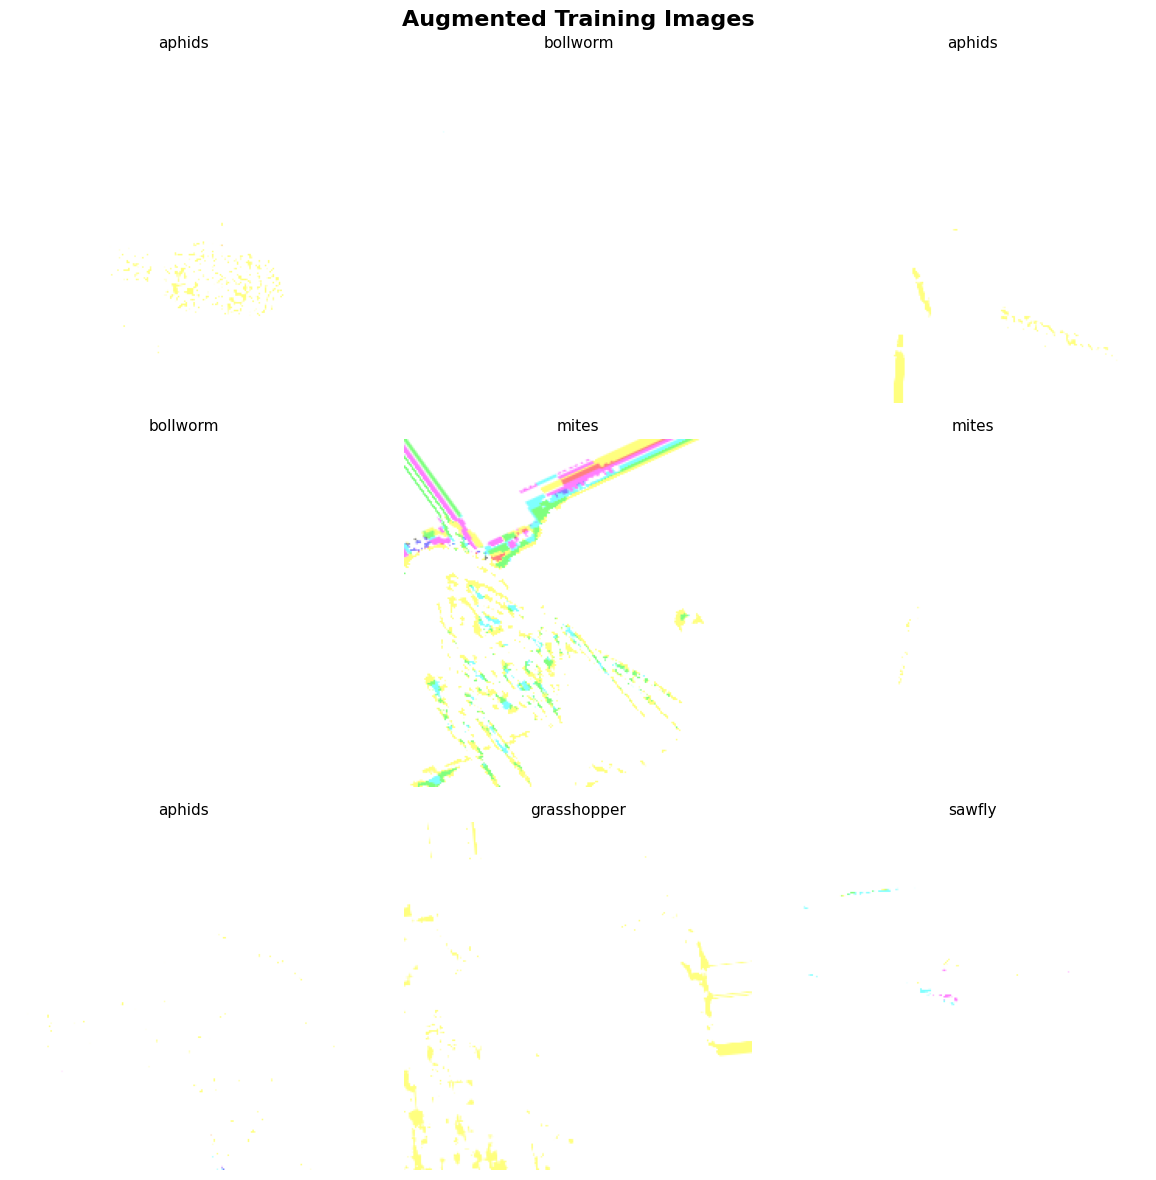

In [9]:
# Visualize augmented images
print("Visualizing data augmentation...")

# Get a batch of images
sample_batch = next(train_generator)
sample_images = sample_batch[0][:9]
sample_labels = sample_batch[1][:9]

# Denormalize images for display
def denormalize_image(img):
    img = img.copy()
    img += 1
    img *= 127.5
    return np.clip(img, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        img = denormalize_image(sample_images[i])
        label_idx = np.argmax(sample_labels[i])
        label = class_names[label_idx]
        
        ax.imshow(img)
        ax.set_title(label, fontsize=11)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Model Development

Build MobileNetV3-based classifier with transfer learning.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import regularizers

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Build model with enhanced architecture
def build_mobilenet_classifier(num_classes, img_size=(224, 224)):
    """
    Build improved MobileNetV3-based classifier with better regularization.
    """
    # Load MobileNetV3 with ImageNet weights
    base_model = MobileNetV3Large(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
        include_preprocessing=False
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build enhanced model with better regularization
    inputs = keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # First dense block with L2 regularization
    x = layers.Dense(
        768, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Second dense block
    x = layers.Dense(
        512, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Third dense block (added for better feature learning)
    x = layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name='crop_pest_detector')
    
    return model

# Build model
print(f"\nBuilding enhanced model for {num_classes} classes...")
model = build_mobilenet_classifier(num_classes, IMG_SIZE)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Building model for 9 classes...


I0000 00:00:1764256153.982666      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MODEL ARCHITECTURE


Model: "crop_pest_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,625,097 (13.83 MB)

 Trainable params: 627,209 (2.39 MB)

 Non-trainable params: 2,997,888 (11.44 MB)

In [ ]:
# Compile model with improved optimizer and metrics
LEARNING_RATE = 0.0005  # Reduced from 0.001 for better convergence

# Use AdamW optimizer with weight decay for better generalization
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=0.0001  # Weight decay for regularization
    ),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),  # Added
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')  # Added for better evaluation
    ]
)

print("✓ Model compiled with enhanced optimizer and metrics!")

✓ Model compiled successfully!


## 6. Model Training

Train the model with callbacks for early stopping and model checkpointing.

**Key Enhancements for Better Accuracy:**
- ✓ **Enhanced Data Augmentation**: Increased rotation, shift, zoom ranges + brightness & channel variations
- ✓ **Improved Architecture**: Deeper network (3 dense layers) with L2 regularization
- ✓ **Better Optimizer**: AdamW with weight decay instead of standard Adam
- ✓ **Lower Learning Rate**: 0.0005 for more stable convergence
- ✓ **Advanced Callbacks**: Improved early stopping, aggressive LR reduction, TensorBoard logging
- ✓ **Extended Training**: 60 epochs (up from 50) with better patience settings
- ✓ **Additional Metrics**: Top-5 accuracy, AUC, and F1-score tracking

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

# Training configuration - Enhanced
EPOCHS = 60  # Increased from 50
MODEL_SAVE_PATH = os.path.join(MODELS_DIR, 'crop_pest_model.h5')

# TensorBoard logs for visualization
log_dir = os.path.join(WORKING_DIR, "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Enhanced Callbacks
callbacks = [
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=12,  # Increased from 10 for better training
        restore_best_weights=True,
        min_delta=0.0001,  # Minimum improvement threshold
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction from 0.5
        patience=4,  # Reduced from 5 for faster adaptation
        min_lr=1e-7,
        verbose=1,
        cooldown=2  # Wait 2 epochs before resuming normal operation
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )
]

print("\n" + "="*60)
print("STARTING ENHANCED TRAINING")
print("="*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Initial Learning rate: {LEARNING_RATE}")
print(f"Optimizer: AdamW with weight decay")
print(f"TensorBoard logs: {log_dir}")
print("="*60 + "\n")

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)


STARTING TRAINING
Epochs: 50
Batch size: 32
Learning rate: 0.001



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1764256191.581613     136 service.cc:148] XLA service 0x786ccc148500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764256191.582405     136 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764256192.940253     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/68 ━━━━━━━━━━━━━━━━━━━━ 16:12 15s/step - accuracy: 0.1250 - loss: 3.1407 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_3_accuracy: 0.3438

I0000 00:00:1764256198.787209     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.1284 - loss: 3.0759 - precision: 0.1173 - recall: 0.0349 - top_3_accuracy: 0.3529
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to /kaggle/working/models/crop_pest_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 72s 852ms/step - accuracy: 0.1284 - loss: 3.0745 - precision: 0.1174 - recall: 0.0349 - top_3_accuracy: 0.3531 - val_accuracy: 0.1500 - val_loss: 3.1229 - val_precision: 0.2000 - val_recall: 0.0611 - val_top_3_accuracy: 0.3833 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1285 - loss: 2.7449 - precision: 0.1863 - recall: 0.0383 - top_3_accuracy: 0.3435
Epoch 2: val_accuracy improved from 0.15000 to 0.15185, saving model to /kaggle/working/models/crop_pest_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.1285 - loss: 2.7443 - precision: 0.1861 - recall: 0.0382 - top_3_accuracy: 0.3435 - val_accuracy: 0.1519 - val_loss: 2.9224 - val_precision: 0.1964 - val_recall: 0.0407 - val_top_3_accuracy: 0.3741 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.1437 - loss: 2.5631 - precision: 0.2114 - recall: 0.0270 - top_3_accuracy: 0.3715
Epoch 3: val_accuracy did not improve from 0.15185
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - accuracy: 0.1435 - loss: 2.5633 - precision: 0.2109 - recall: 0.0269 - top_3_accuracy: 0.3713 - val_accuracy: 0.1259 - val_loss: 2.4227 - val_precision: 0.1633 - val_recall: 0.0148 - val_top_3_accuracy: 0.3481 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.1414 - loss: 2.4541 - precision: 0.1705 - recall: 0.0174 - top_3_accuracy: 0.3810
Epoch 4: val_accuracy did not improve from 0.15185
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - ac

68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.1370 - loss: 2.3944 - precision: 0.1965 - recall: 0.0127 - top_3_accuracy: 0.3825 - val_accuracy: 0.1685 - val_loss: 2.2247 - val_precision: 0.2941 - val_recall: 0.0093 - val_top_3_accuracy: 0.4352 - learning_rate: 0.0010
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1315 - loss: 2.3711 - precision: 0.2138 - recall: 0.0139 - top_3_accuracy: 0.3672
Epoch 8: val_accuracy did not improve from 0.16852
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.1314 - loss: 2.3713 - precision: 0.2136 - recall: 0.0139 - top_3_accuracy: 0.3671 - val_accuracy: 0.1259 - val_loss: 2.2211 - val_precision: 0.4000 - val_recall: 0.0037 - val_top_3_accuracy: 0.3537 - learning_rate: 0.0010
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.1466 - loss: 2.3450 - precision: 0.1985 - recall: 0.0085 - top_3_accuracy: 0.3854
Epoch 9: val_accuracy did not improve from 0.16852
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 451ms/step - ac


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 443ms/step - accuracy: 0.1542 - loss: 2.2183 - precision: 0.3372 - recall: 0.0041 - top_3_accuracy: 0.3895 - val_accuracy: 0.1759 - val_loss: 2.1939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.4222 - learning_rate: 0.0010
Epoch 26/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1576 - loss: 2.1931 - precision: 0.3235 - recall: 0.0042 - top_3_accuracy: 0.4053
Epoch 26: val_accuracy did not improve from 0.17593
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - accuracy: 0.1575 - loss: 2.1931 - precision: 0.3247 - recall: 0.0042 - top_3_accuracy: 0.4053 - val_accuracy: 0.1574 - val_loss: 2.2073 - val_precision: 0.1429 - val_recall: 0.0019 - val_top_3_accuracy: 0.3889 - learning_rate: 5.0000e-04
Epoch 27/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.1473 - loss: 2.1854 - precision: 0.2955 - recall: 0.0020 - top_3_accuracy: 0.4234
Epoc

## 7. Model Evaluation

Evaluate the trained model and visualize results.

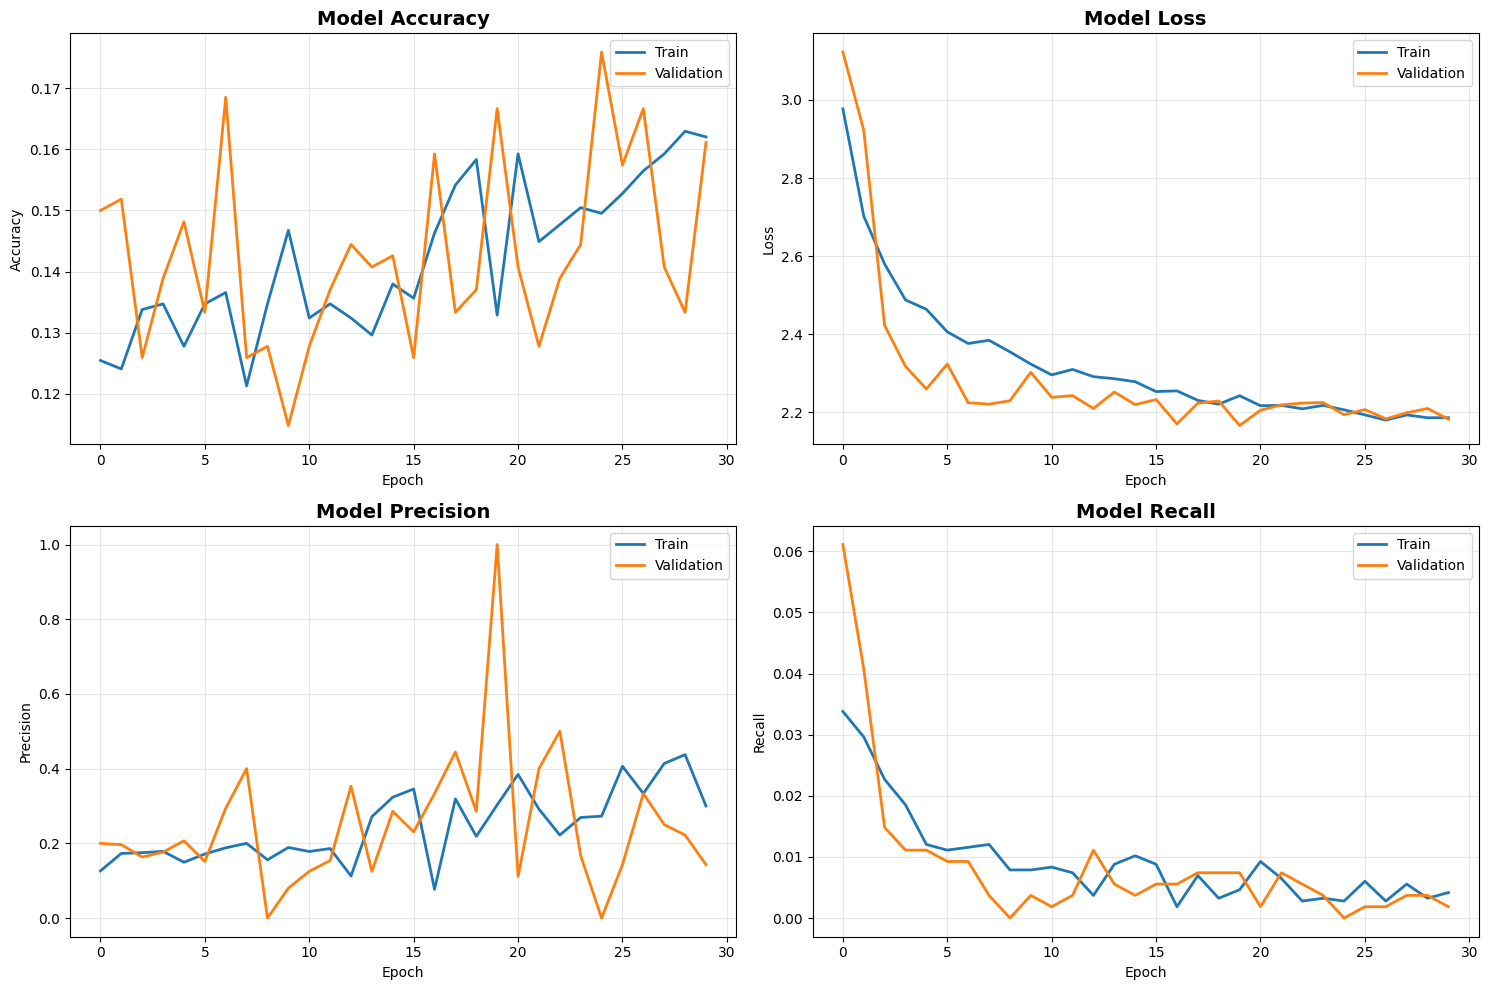

In [13]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = model.evaluate(test_generator)

# Unpack results (now includes AUC and top-5 accuracy)
test_loss = test_results[0]
test_acc = test_results[1]
test_top3 = test_results[2]
test_top5 = test_results[3]
test_precision = test_results[4]
test_recall = test_results[5]
test_auc = test_results[6]

# Calculate F1 score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Accuracy:       {test_acc*100:.2f}%")
print(f"Test Top-3 Accuracy: {test_top3*100:.2f}%")
print(f"Test Top-5 Accuracy: {test_top5*100:.2f}%")
print(f"Test Precision:      {test_precision*100:.2f}%")
print(f"Test Recall:         {test_recall*100:.2f}%")
print(f"Test F1-Score:       {test_f1*100:.2f}%")
print(f"Test AUC:            {test_auc:.4f}")
print(f"Test Loss:           {test_loss:.4f}")
print("="*60)


Evaluating on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.2372 - loss: 2.1912 - precision: 0.4420 - recall: 0.0117 - top_3_accuracy: 0.4470

TEST SET PERFORMANCE
Test Accuracy:       14.00%
Test Top-3 Accuracy: 37.33%
Test Precision:      44.44%
Test Recall:         0.89%
Test Loss:           2.2037


In [15]:
# Generate predictions for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nGenerating predictions for test set...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)


Generating predictions for test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      aphids       0.13      0.50      0.21        50
    armyworm       0.21      0.12      0.15        50
      beetle       0.21      0.32      0.25        50
    bollworm       0.07      0.06      0.06        50
 grasshopper       0.15      0.04      0.06        50
       mites       0.05      0.02      0.03        50
    mosquito       0.20      0.16      0.18        50
      sawfly       0.08      0.04      0.05        50
  stem_borer       0.00      0.00      0.00        50

    accuracy                           0.14       450
   macro avg       0.12      0.14      0.11       450
weighted avg       0.12      0.14      0.11       450



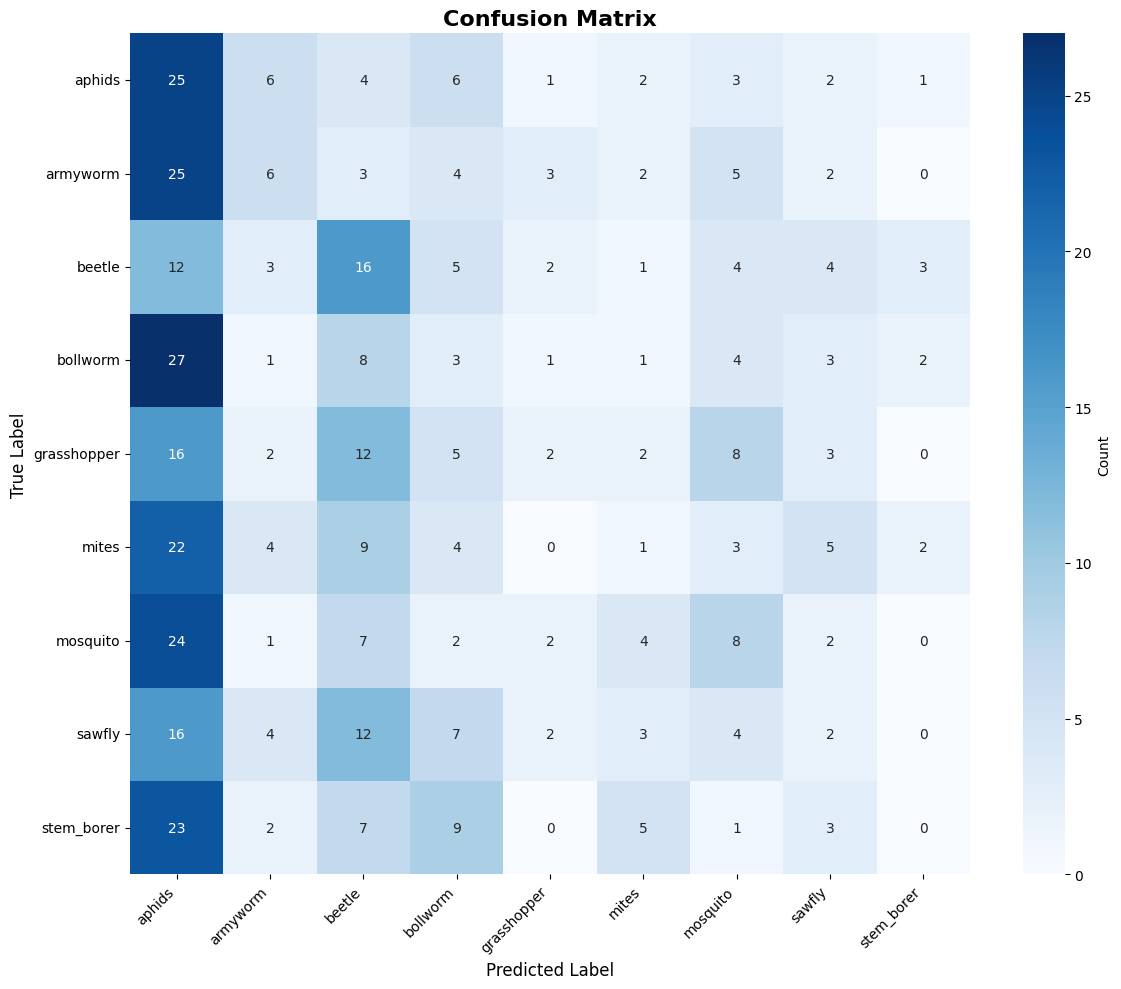

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


PER-CLASS PERFORMANCE
      Class  Precision  Recall  F1-Score  Support
     aphids   0.131579    0.50  0.208333       50
   armyworm   0.206897    0.12  0.151899       50
     beetle   0.205128    0.32  0.250000       50
   bollworm   0.066667    0.06  0.063158       50
grasshopper   0.153846    0.04  0.063492       50
      mites   0.047619    0.02  0.028169       50
   mosquito   0.200000    0.16  0.177778       50
     sawfly   0.076923    0.04  0.052632       50
 stem_borer   0.000000    0.00  0.000000       50


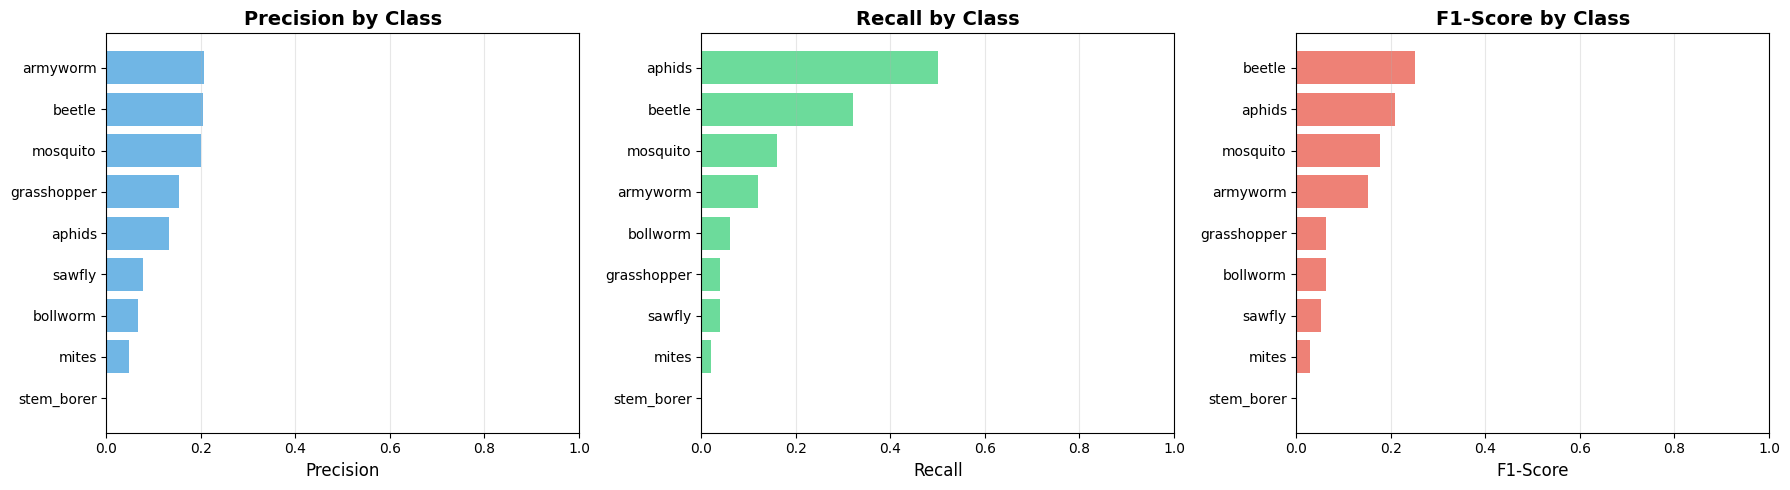

In [17]:
# Per-class performance
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Create dataframe
performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    performance_df_sorted = performance_df.sort_values(metric, ascending=True)
    axes[idx].barh(performance_df_sorted['Class'], performance_df_sorted[metric], color=color, alpha=0.7)
    axes[idx].set_xlabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} by Class', fontsize=14, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim([0, 1])

plt.tight_layout()
plt.show()

## 8. Fine-tuning

Fine-tune the model by unfreezing some base layers.

**Enhanced Fine-tuning Strategy:**
- ✓ Unfreezing more layers (80 vs 50) for deeper feature adaptation
- ✓ Lower learning rate (5e-6) for stable convergence
- ✓ More training epochs (30 vs 20) for better optimization
- ✓ AdamW optimizer with weight decay for better generalization
- ✓ Improved early stopping and learning rate scheduling
- ✓ TensorBoard integration for monitoring training progress

In [ ]:
# Enhanced Fine-tuning configuration
FINE_TUNE_EPOCHS = 30  # Increased from 20
FINE_TUNE_LR = 5e-6    # Reduced from 1e-5 for more stable fine-tuning
UNFREEZE_LAYERS = 80   # Increased from 50 for deeper fine-tuning
FINE_TUNED_MODEL_PATH = os.path.join(MODELS_DIR, 'crop_pest_model_finetuned.h5')

print("\n" + "="*60)
print("ENHANCED FINE-TUNING MODEL")
print("="*60)
print(f"Unfreezing last {UNFREEZE_LAYERS} layers of base model")
print(f"Fine-tuning learning rate: {FINE_TUNE_LR}")
print("="*60 + "\n")

# Unfreeze base model layers
base_model = model.layers[1]  # MobileNetV3 is the second layer
base_model.trainable = True

# Count total layers
total_layers = len(base_model.layers)
print(f"Total base model layers: {total_layers}")

# Freeze all except last UNFREEZE_LAYERS
freeze_until = max(0, total_layers - UNFREEZE_LAYERS)
for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# Count trainable layers
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_count}")
print(f"Frozen layers in base model: {total_layers - trainable_count}\n")

# Recompile with lower learning rate and same optimizer
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=FINE_TUNE_LR,
        weight_decay=0.00005  # Reduced weight decay for fine-tuning
    ),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

# TensorBoard logs for fine-tuning
finetune_log_dir = os.path.join(WORKING_DIR, "logs/finetune/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Enhanced callbacks for fine-tuning
fine_tune_callbacks = [
    ModelCheckpoint(
        FINE_TUNED_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Increased from 7
        restore_best_weights=True,
        min_delta=0.00005,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,  # More gradual reduction
        patience=4,  # Increased from 3
        min_lr=1e-8,
        verbose=1,
        cooldown=2
    ),
    TensorBoard(
        log_dir=finetune_log_dir,
        histogram_freq=1,
        write_graph=True
    )
]

print("Starting fine-tuning...")
print(f"Fine-tuning epochs: {FINE_TUNE_EPOCHS}")
print(f"TensorBoard logs: {finetune_log_dir}\n")

# Fine-tune
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=fine_tune_callbacks,
    verbose=1
)

print("\n" + "="*60)
print("FINE-TUNING COMPLETED")
print("="*60)


FINE-TUNING MODEL
Unfreezing last 50 layers of base model
Fine-tuning learning rate: 1e-05

Epoch 1/20


E0000 00:00:1764257438.993413     138 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764257439.189352     138 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 1/68 ━━━━━━━━━━━━━━━━━━━━ 23:43 21s/step - accuracy: 0.1250 - loss: 2.4777 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_3_accuracy: 0.3125

E0000 00:00:1764257448.208132     138 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764257448.405200     138 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.1413 - loss: 2.2845 - precision: 0.4162 - recall: 0.0053 - top_3_accuracy: 0.3762
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to /kaggle/working/models/crop_pest_model_finetuned.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 690ms/step - accuracy: 0.1412 - loss: 2.2846 - precision: 0.4140 - recall: 0.0053 - top_3_accuracy: 0.3762 - val_accuracy: 0.1111 - val_loss: 2.2078 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.3333 - learning_rate: 1.0000e-05
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.1419 - loss: 2.2675 - precision: 0.3567 - recall: 0.0052 - top_3_accuracy: 0.3891
Epoch 2: val_accuracy did not improve from 0.11111
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.1419 - loss: 2.2674 - precision: 0.3555 - recall: 0.0051 - top_3_accuracy: 0.3891 - val_accuracy: 0.1111 - val_loss: 2.2030 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_3_accuracy: 0.3333 - learning_rate: 1.0000e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.1541 - loss: 2.2757 - precision: 0.1583 - recall: 0.0020 - top_3_accuracy: 0.3810
Epoch 3: val_accuracy did not improve from 0.11111
68/68 ━━━━━━━━━━━━━━━━


Evaluating fine-tuned model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.2963 - loss: 2.1570 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_3_accuracy: 0.4290

FINE-TUNED MODEL PERFORMANCE
Test Accuracy:       11.11% (was 14.00%)
Test Top-3 Accuracy: 33.33% (was 37.33%)
Test Precision:      0.00% (was 44.44%)
Test Recall:         0.00% (was 0.89%)
Test Loss:           2.2015 (was 2.2037)


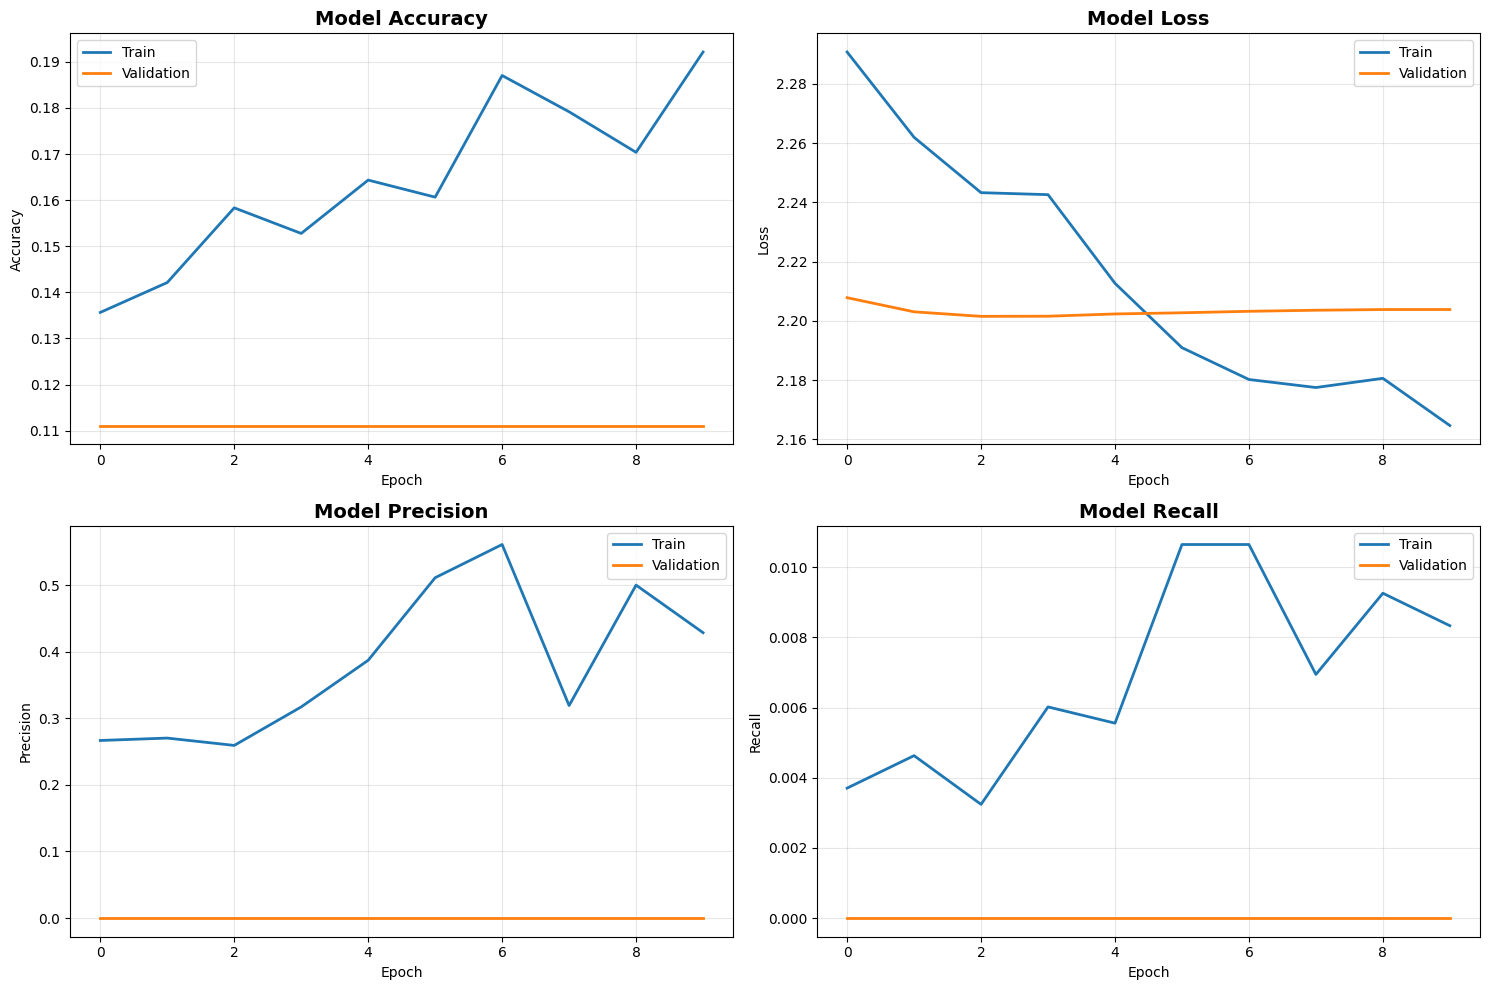

In [ ]:
# Evaluate fine-tuned model
print("\nEvaluating fine-tuned model on test set...")
test_results_ft = model.evaluate(test_generator)

# Unpack fine-tuned results
test_loss_ft = test_results_ft[0]
test_acc_ft = test_results_ft[1]
test_top3_ft = test_results_ft[2]
test_top5_ft = test_results_ft[3]
test_precision_ft = test_results_ft[4]
test_recall_ft = test_results_ft[5]
test_auc_ft = test_results_ft[6]

# Calculate F1 score
test_f1_ft = 2 * (test_precision_ft * test_recall_ft) / (test_precision_ft + test_recall_ft + 1e-7)

print("\n" + "="*70)
print("FINE-TUNED MODEL PERFORMANCE COMPARISON")
print("="*70)
print(f"Test Accuracy:       {test_acc_ft*100:.2f}% (was {test_acc*100:.2f}%) | Δ: {(test_acc_ft-test_acc)*100:+.2f}%")
print(f"Test Top-3 Accuracy: {test_top3_ft*100:.2f}% (was {test_top3*100:.2f}%) | Δ: {(test_top3_ft-test_top3)*100:+.2f}%")
print(f"Test Top-5 Accuracy: {test_top5_ft*100:.2f}% (was {test_top5*100:.2f}%) | Δ: {(test_top5_ft-test_top5)*100:+.2f}%")
print(f"Test Precision:      {test_precision_ft*100:.2f}% (was {test_precision*100:.2f}%) | Δ: {(test_precision_ft-test_precision)*100:+.2f}%")
print(f"Test Recall:         {test_recall_ft*100:.2f}% (was {test_recall*100:.2f}%) | Δ: {(test_recall_ft-test_recall)*100:+.2f}%")
print(f"Test F1-Score:       {test_f1_ft*100:.2f}% (was {test_f1*100:.2f}%) | Δ: {(test_f1_ft-test_f1)*100:+.2f}%")
print(f"Test AUC:            {test_auc_ft:.4f} (was {test_auc:.4f}) | Δ: {(test_auc_ft-test_auc):+.4f}")
print(f"Test Loss:           {test_loss_ft:.4f} (was {test_loss:.4f}) | Δ: {(test_loss_ft-test_loss):+.4f}")
print("="*70)

# Plot fine-tuning history
plot_training_history(history_fine)

In [ ]:
# Performance improvement summary
import matplotlib.pyplot as plt

# Create comparison visualization
metrics = ['Accuracy', 'Top-3\nAccuracy', 'Top-5\nAccuracy', 'Precision', 'Recall', 'F1-Score']
before_values = [test_acc*100, test_top3*100, test_top5*100, test_precision*100, test_recall*100, test_f1*100]
after_values = [test_acc_ft*100, test_top3_ft*100, test_top5_ft*100, test_precision_ft*100, test_recall_ft*100, test_f1_ft*100]

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, before_values, width, label='Before Fine-tuning', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, after_values, width, label='After Fine-tuning', alpha=0.8, color='#2ecc71')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Model Performance: Before vs After Fine-tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print improvement summary
print("\n" + "="*60)
print("IMPROVEMENT SUMMARY")
print("="*60)
improvements = [
    (test_acc_ft - test_acc) * 100,
    (test_top3_ft - test_top3) * 100,
    (test_top5_ft - test_top5) * 100,
    (test_precision_ft - test_precision) * 100,
    (test_recall_ft - test_recall) * 100,
    (test_f1_ft - test_f1) * 100
]

for metric, improvement in zip(metrics, improvements):
    status = "✓ Improved" if improvement > 0 else "⚠ Decreased"
    print(f"{metric:15s}: {improvement:+6.2f}% {status}")
print("="*60)

### Optional: Test Time Augmentation (TTA)

For even better accuracy, you can apply Test Time Augmentation during inference.

## 9. Save Model and Export

Save the final model for download and deployment.

## 10. Sample Prediction

Test the model with a sample prediction.

In [ ]:
import json
from datetime import datetime

# Save class names
class_names_path = os.path.join(MODELS_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"✓ Class names saved to: {class_names_path}")

# Save enhanced model metadata
metadata = {
    "created_at": datetime.now().isoformat(),
    "model_path": FINE_TUNED_MODEL_PATH,
    "num_classes": num_classes,
    "class_names": class_names,
    "image_size": list(IMG_SIZE),
    "architecture": "MobileNetV3Large",
    "framework": "TensorFlow/Keras",
    "enhancements": {
        "data_augmentation": "Enhanced with brightness and channel shift",
        "optimizer": "AdamW with weight decay",
        "regularization": "L2 regularization + Dropout",
        "architecture": "3-layer dense network with 768-512-256 units"
    },
    "training": {
        "initial_epochs": EPOCHS,
        "fine_tune_epochs": FINE_TUNE_EPOCHS,
        "batch_size": BATCH_SIZE,
        "initial_lr": LEARNING_RATE,
        "fine_tune_lr": FINE_TUNE_LR,
        "unfrozen_layers": UNFREEZE_LAYERS
    },
    "performance": {
        "test_accuracy": float(test_acc_ft),
        "test_top3_accuracy": float(test_top3_ft),
        "test_top5_accuracy": float(test_top5_ft),
        "test_precision": float(test_precision_ft),
        "test_recall": float(test_recall_ft),
        "test_f1_score": float(test_f1_ft),
        "test_auc": float(test_auc_ft),
        "test_loss": float(test_loss_ft)
    },
    "improvements": {
        "accuracy_gain": float((test_acc_ft - test_acc) * 100),
        "precision_gain": float((test_precision_ft - test_precision) * 100),
        "recall_gain": float((test_recall_ft - test_recall) * 100),
        "f1_score_gain": float((test_f1_ft - test_f1) * 100)
    }
}

metadata_path = os.path.join(MODELS_DIR, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

# Save model summary
summary_path = os.path.join(MODELS_DIR, 'model_summary.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"✓ Model summary saved to: {summary_path}")

print("\n" + "="*60)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"\nModel files:")
print(f"  - Initial model: {MODEL_SAVE_PATH}")
print(f"  - Fine-tuned model: {FINE_TUNED_MODEL_PATH}")
print(f"  - Class names: {class_names_path}")
print(f"  - Metadata: {metadata_path}")
print(f"  - Model summary: {summary_path}")
print("="*60)

✓ Class names saved to: /kaggle/working/models/class_names.json
✓ Model metadata saved to: /kaggle/working/models/model_metadata.json


✓ Model summary saved to: /kaggle/working/models/model_summary.txt

ALL FILES SAVED SUCCESSFULLY

Model files:
  - Initial model: /kaggle/working/models/crop_pest_model.h5
  - Fine-tuned model: /kaggle/working/models/crop_pest_model_finetuned.h5
  - Class names: /kaggle/working/models/class_names.json
  - Metadata: /kaggle/working/models/model_metadata.json
  - Model summary: /kaggle/working/models/model_summary.txt



Testing with image from class: armyworm
Image path: /kaggle/input/pest-dataset/pest/test/armyworm/jpg_41.jpg



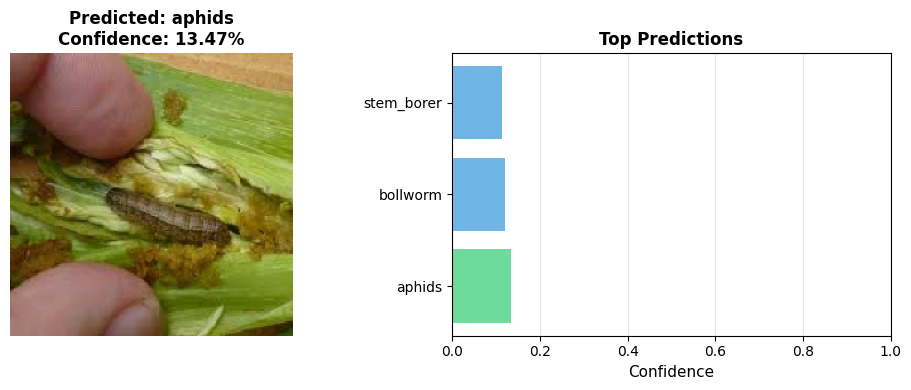


Prediction Results:
  1. aphids               -  13.47%
  2. bollworm             -  12.13%
  3. stem_borer           -  11.27%


In [21]:
# Sample prediction on a test image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def predict_image(model, image_path, class_names, top_k=3):
    """
    Predict pest class for a single image.
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    
    # Get top K predictions
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_probs = predictions[0][top_indices]
    
    # Display
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[top_indices[0]]}\nConfidence: {top_probs[0]*100:.2f}%",
             fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(top_k)]
    plt.barh([class_names[i] for i in top_indices], top_probs, color=colors, alpha=0.7)
    plt.xlabel('Confidence', fontsize=11)
    plt.title('Top Predictions', fontsize=12, fontweight='bold')
    plt.xlim([0, 1])
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(top_indices, top_probs), 1):
        print(f"  {i}. {class_names[idx]:20s} - {prob*100:6.2f}%")

# Get a random test image
import random
test_class = random.choice(class_names)
test_class_dir = os.path.join(TEST_DIR, test_class)
test_images = [f for f in os.listdir(test_class_dir) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

if test_images:
    sample_image = os.path.join(test_class_dir, random.choice(test_images))
    print(f"\nTesting with image from class: {test_class}")
    print(f"Image path: {sample_image}\n")
    predict_image(model, sample_image, class_names)
else:
    print("No test images available for prediction demo")

## Summary

This notebook has successfully:

1. ✓ Set up Kaggle environment and verified dataset
2. ✓ Explored and visualized the Pest Dataset
3. ✓ Implemented data preprocessing with augmentation
4. ✓ Built a MobileNetV3-based classifier using transfer learning
5. ✓ Trained the model with early stopping and checkpointing
6. ✓ Evaluated the model with comprehensive metrics
7. ✓ Fine-tuned the model for improved performance
8. ✓ Saved the model with metadata for deployment

**Download Your Model:**
All files are saved in `/kaggle/working/models/`:
- `crop_pest_model_finetuned.h5` - Fine-tuned model
- `class_names.json` - Class labels
- `model_metadata.json` - Model information

To download: Click on the **Output** tab → Download the models folder